In [33]:
import numpy as np
from numpy import ma
import math
import scipy
import scipy.constants as constants
import os
from IPython.display import Image

from netCDF4 import Dataset

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib import ticker

# from matplotlib.mlab import bivariate_normal

NA = 6.022e+23

In [34]:
# Lagrange: 2x2.5

FILEDIR0 = '/n/home12/hongwei/HONGWEI/GC_run_13.0/gc_2x25_aerosol_compare_lagrange/'
NcFile0   = Dataset(FILEDIR0+'OutputDir/GEOSChem.SpeciesConc.20120101_0000z.nc4','r',format='NETCDF4_CLASSIC')

lat0             = NcFile0.variables['lat'][:]
lon0             = NcFile0.variables['lon'][:]
LA0              = NcFile0.variables['SpeciesConc_PASV_LA'][:,:,:,:]
LA0_3            = NcFile0.variables['SpeciesConc_PASV_LA3'][:,:,:,:]

LA0 = LA0 + LA0_3

GC_AREA0 = NcFile0.variables['AREA'][:,:]



# Eulerian: 0.5x0.625
FILEDIR1 = '/n/home12/hongwei/HONGWEI/GC_run_13.0/gc_2x25_aerosol_compare_Eulerian/'
NcFile1   = Dataset(FILEDIR1+'OutputDir/GEOSChem.SpeciesConc.20120101_0000z.nc4','r',format='NETCDF4_CLASSIC')

lat1             = NcFile1.variables['lat'][:]
lon1             = NcFile1.variables['lon'][:]
EU1              = NcFile1.variables['SpeciesConc_PASV_EU'][:,:,:,:]

GC_AREA1 = NcFile1.variables['AREA'][:,:];


# Eulerian: 1.0x1.25
FILEDIR2 = '/n/home12/hongwei/HONGWEI/GC_run_13.0/gc_2x25_aerosol_compare_Eulerian/'
NcFile2   = Dataset(FILEDIR2+'OutputDir/GEOSChem.SpeciesConc.20120101_0000z.nc4','r',format='NETCDF4_CLASSIC')

lat2             = NcFile2.variables['lat'][:]
lon2             = NcFile2.variables['lon'][:]
EU2              = NcFile2.variables['SpeciesConc_PASV_EU'][:,:,:,:]

GC_AREA2 = NcFile2.variables['AREA'][:,:];


# Eulerian: 2x2.5
FILEDIR3 = '/n/home12/hongwei/HONGWEI/GC_run_13.0/gc_2x25_aerosol_compare_Eulerian/'
NcFile3   = Dataset(FILEDIR3+'OutputDir/GEOSChem.SpeciesConc.20120101_0000z.nc4','r',format='NETCDF4_CLASSIC')

lat3             = NcFile3.variables['lat'][:]
lon3             = NcFile3.variables['lon'][:]
EU3              = NcFile3.variables['SpeciesConc_PASV_EU'][:,:,:,:]

GC_AREA3 = NcFile3.variables['AREA'][:,:];


# Eulerian: 4x5
FILEDIR4 = '/n/home12/hongwei/HONGWEI/GC_run_13.0/gc_2x25_aerosol_compare_Eulerian/'
NcFile4   = Dataset(FILEDIR4+'OutputDir/GEOSChem.SpeciesConc.20120101_0000z.nc4','r',format='NETCDF4_CLASSIC')

lat4             = NcFile4.variables['lat']
lon4             = NcFile4.variables['lon']
EU4              = NcFile4.variables['SpeciesConc_PASV_EU']

GC_AREA4 = NcFile4.variables['AREA'][:,:]


EU4

<class 'netCDF4._netCDF4.Variable'>
float32 SpeciesConc_PASV_EU(time, lev, lat, lon)
    long_name: Dry mixing ratio of species PASV_EU
    units: mol mol-1 dry
    averaging_method: instantaneous
unlimited dimensions: time
current shape = (31, 72, 91, 144)
filling off

In [35]:
#------------------------------------------------
# total air mass in each grid  ------------------
#------------------------------------------------

# Lagrnage: 2x2.5
AD_file0 = open(FILEDIR0+'State_Met_AD.txt','r')

GC_AD0 = LA0[0,:,:,:]*0.0

Nx0 = len(LA0[0,0,0,:])
Ny0 = len(LA0[0,0,:,0])
Nz0 = len(LA0[0,:,0,0])
Nt0 = len(LA0[:,0,0,0])

for ix in range(Nx0):
    for iy in range(Ny0):
        for iz in range(Nz0):
            line = AD_file0.readline()
            GC_AD0[iz,iy,ix] = float(line)


# Eulerian: 0.5x0.625
AD_file1 = open(FILEDIR1+'State_Met_AD.txt','r')

GC_AD1 = EU1[0,:,:,:]*0.0

Nx1 = len(EU1[0,0,0,:])
Ny1 = len(EU1[0,0,:,0])
Nz1 = len(EU1[0,:,0,0])
Nt1 = len(EU1[:,0,0,0])

for ix in range(Nx1):
    for iy in range(Ny1):
        for iz in range(Nz1):
            line = AD_file1.readline()
            GC_AD1[iz,iy,ix] = float(line)
            

            
# Eulerian: 1x1.125
AD_file2 = open(FILEDIR2+'State_Met_AD.txt','r')

GC_AD2 = EU2[0,:,:,:]*0.0

Nx2 = len(EU2[0,0,0,:])
Ny2 = len(EU2[0,0,:,0])
Nz2 = len(EU2[0,:,0,0])
Nt2 = len(EU2[:,0,0,0])

for ix in range(Nx2):
    for iy in range(Ny2):
        for iz in range(Nz2):
            line = AD_file2.readline()
            GC_AD2[iz,iy,ix] = float(line)
            
            
            
# Eulerian: 2x2.5
AD_file3 = open(FILEDIR3+'State_Met_AD.txt','r')

GC_AD3 = EU3[0,:,:,:]*0.0

Nx3 = len(EU3[0,0,0,:])
Ny3 = len(EU3[0,0,:,0])
Nz3 = len(EU3[0,:,0,0])
Nt3 = len(EU3[:,0,0,0])

for ix in range(Nx3):
    for iy in range(Ny3):
        for iz in range(Nz3):
            line = AD_file3.readline()
            GC_AD3[iz,iy,ix] = float(line)
            
            
# Eulerian: 4x5
AD_file4 = open(FILEDIR4+'State_Met_AD.txt','r')

GC_AD4 = EU4[0,:,:,:]*0.0

Nx4 = len(EU4[0,0,0,:])
Ny4 = len(EU4[0,0,:,0])
Nz4 = len(EU4[0,:,0,0])
Nt4 = len(EU4[:,0,0,0])

for ix in range(Nx4):
    for iy in range(Ny4):
        for iz in range(Nz4):
            line = AD_file4.readline()
            GC_AD4[iz,iy,ix] = float(line)

In [36]:
# 3-D entropy

k = constants.k
print(f'Boltzmann constant={k}')

# change total air mass from kg to mol

AD1_mol = GC_AD1[:,:,:]*1000.0/28.97
AD0_mol = GC_AD0[:,:,:]*1000.0/28.97

# entropy

Entropy3d_EU1, Entropy3d_LA0 = [], []

for it in range(Nt1):
    S_EU1 = -k*np.sum( GC_AD1[:,:,:]*EU1[it,:,:,:]* np.log(EU1[it,:,:,:], out=np.zeros_like(EU1[it,:,:,:]), \
                                                           where=(EU1[it,:,:,:]!=0)), axis=(0,1,2) )

    S_LA0 = -k*np.sum( GC_AD0[:,:,:]*LA0[it,:,:,:]* np.log(LA0[it,:,:,:], out=np.zeros_like(LA0[it,:,:,:]), \
                                                           where=(LA0[it,:,:,:]!=0)), axis=(0,1,2) )
    
    Entropy3d_EU1.append(S_EU1)
    Entropy3d_LA0.append(S_LA0)

    
# print(Entropy3d_EU1, Entropy3d_LA1)
# print(Entropy3d_EU2, Entropy3d_LA2)



Boltzmann constant=1.380649e-23


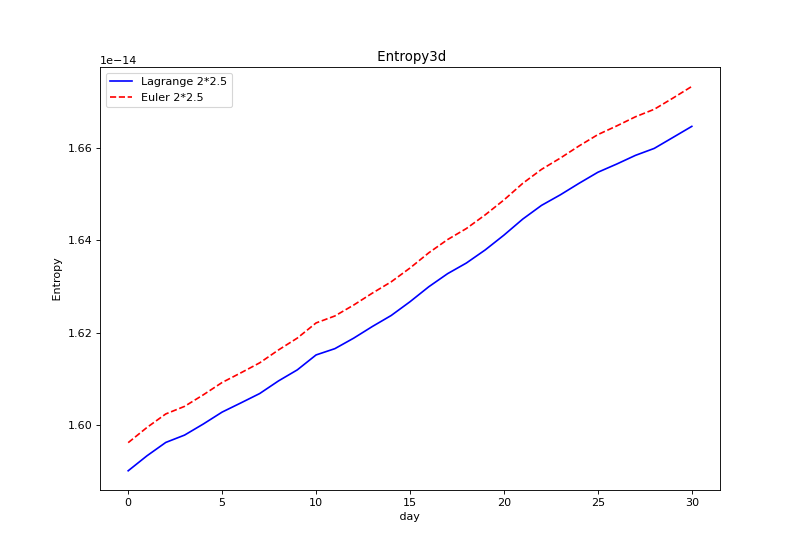

In [37]:
# Plot CFD curve: mass vs. area
plt.figure(figsize=(10,7), dpi= 80)

plt.plot(Entropy3d_LA0,'b',label=f'Lagrange 2*2.5')

plt.plot(Entropy3d_EU1,'r--',label=f'Euler 2*2.5')


#plt.legend(loc='upper left')
plt.title(' Entropy3d')
plt.xlabel(' day ')
plt.ylabel(' Entropy ')
plt.legend()

plt.savefig('Entropy_time_series.png')
plt.clf();
plt.cla();
plt.close();

Image('Entropy_time_series.png') 

In [38]:
# 2-D entropy corresponding to the below contour figure

k = constants.k
print(f'Boltzmann constant={k}')

# change total air mass from kg to mol:
AD1_mol = GC_AD1[:,:,:]*1000.0/28.97
AD0_mol = GC_AD0[:,:,:]*1000.0/28.97


Entropy2d_EU1, Entropy2d_LA0 = [], []


AD1_mol_Zsum = np.sum(AD1_mol, axis=0)
AD0_mol_Zsum = np.sum(AD0_mol, axis=0)

for it in range(Nt1):
    # change 3D mixing ratio to 2D:
    EU1_mol_Zsum = np.sum( EU1[it,:,:,:]*AD1_mol[:,:,:], axis=0)
    LA0_mol_Zsum = np.sum( LA0[it,:,:,:]*AD0_mol[:,:,:], axis=0)


    # calculate 2D mixing ratio:
    EU1_MR = EU1_mol_Zsum/AD1_mol_Zsum
    LA0_MR = LA0_mol_Zsum/AD0_mol_Zsum


    # entropy
    S2_EU1 = -k*np.sum( AD1_mol_Zsum[:,:]*EU1_MR[:,:]* np.log(EU1_MR[:,:], out=np.zeros_like(EU1_MR[:,:]), \
                                                              where=(EU1_MR[:,:]!=0)), axis=(0,1) )
    S2_LA0 = -k*np.sum( AD0_mol_Zsum[:,:]*LA0_MR[:,:]* np.log(LA0_MR[:,:], out=np.zeros_like(LA0_MR[:,:]), \
                                                              where=(LA0_MR[:,:]!=0)), axis=(0,1) )


    Entropy2d_EU1.append(S2_EU1)
    Entropy2d_LA0.append(S2_LA0)


# print(Entropy2d_EU1, Entropy2d_LA1)
# print(Entropy2d_EU2, Entropy2d_LA2)


Boltzmann constant=1.380649e-23


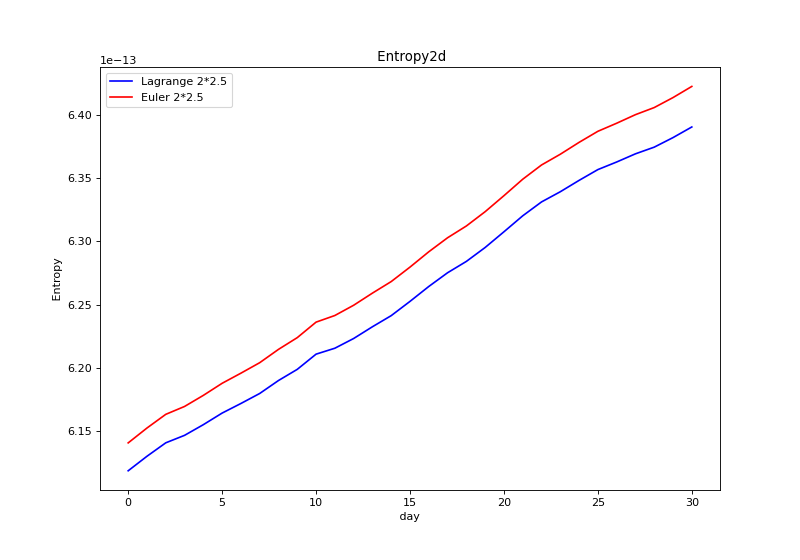

In [39]:
# Plot CFD curve: mass vs. area
plt.figure(figsize=(10,7), dpi= 80)

plt.plot(Entropy2d_LA0,'b',label=f'Lagrange 2*2.5')

plt.plot(Entropy2d_EU1,'r',label=f'Euler 2*2.5')


#plt.legend(loc='upper left')
plt.title(' Entropy2d')
plt.xlabel(' day ')
plt.ylabel(' Entropy ')
plt.legend()

plt.savefig('Entropy_time_series.png')
plt.clf();
plt.cla();
plt.close();

Image('Entropy_time_series.png') 

In [40]:
# for Gini and cumulative distribution function (CDF)

In [41]:
### change unit, do average 

LA0_molec = LA0[:,:,:,:]*0.0
for i in range(Nt0):
    LA0_molec[i,:,:,:] = LA0[i,:,:,:]*(GC_AD0[:,:,:]*1000.0/28.97)*NA

LA0_Zsum = np.sum(LA0_molec[:,:,:,:], axis=1)
for i in range(Nt0):
    LA0_Zsum[i,:,:]   = LA0_Zsum[i,:,:]/GC_AREA0[:,:]/1e4



EU1_molec = EU1[:,:,:,:]*0.0
for i in range(Nt1):
    EU1_molec[i,:,:,:] = EU1[i,:,:,:]*(GC_AD1[:,:,:]*1000.0/28.97)*NA # [mol/mol] to [molec]   

EU1_Zsum = np.sum(EU1_molec[:,:,:,:], axis=1)
for i in range(Nt1):
    EU1_Zsum[i,:,:] = EU1_Zsum[i,:,:]/GC_AREA1[:,:]/1e4 # [molec/cm2]



    
EU2_molec = EU2[:,:,:,:]*0.0
for i in range(Nt2):
    EU2_molec[i,:,:,:] = EU2[i,:,:,:]*(GC_AD2[:,:,:]*1000.0/28.97)*NA # [mol/mol] to [molec]
    
EU2_Zsum = np.sum(EU2_molec[:,:,:,:], axis=1)
for i in range(Nt2):
    EU2_Zsum[i,:,:] = EU2_Zsum[i,:,:]/GC_AREA2[:,:]/1e4 # [molec/cm2]




EU3_molec = EU3[:,:,:,:]*0.0
for i in range(Nt3):
    EU3_molec[i,:,:,:] = EU3[i,:,:,:]*(GC_AD3[:,:,:]*1000.0/28.97)*NA # [mol/mol] to [molec]   

EU3_Zsum = np.sum(EU3_molec[:,:,:,:], axis=1)
for i in range(Nt3):
    EU3_Zsum[i,:,:] = EU3_Zsum[i,:,:]/GC_AREA3[:,:]/1e4 # [molec/cm2]



    
EU4_molec = EU4[:,:,:,:]*0.0
for i in range(Nt4):
    EU4_molec[i,:,:,:] = EU4[i,:,:,:]*(GC_AD4[:,:,:]*1000.0/28.97)*NA # [mol/mol] to [molec]
    
EU4_Zsum = np.sum(EU4_molec[:,:,:,:], axis=1)
for i in range(Nt4):
    EU4_Zsum[i,:,:] = EU4_Zsum[i,:,:]/GC_AREA4[:,:]/1e4 # [molec/cm2]

In [42]:
# delete original variable to save memory
# del LA0, EU1, EU2, EU3, EU4

In [43]:

LA0_area_cumsum_frac_time = []
LA0_mass_cumsum_frac_time = []

EU1_area_cumsum_frac_time = []
EU1_mass_cumsum_frac_time = []

EU2_area_cumsum_frac_time = []
EU2_mass_cumsum_frac_time = []

EU3_area_cumsum_frac_time = []
EU3_mass_cumsum_frac_time = []

EU4_area_cumsum_frac_time = []
EU4_mass_cumsum_frac_time = []


# grid cell area
GC_AREA0_1D = GC_AREA0.reshape(Nx0*Ny0)
GC_AREA1_1D = GC_AREA1.reshape(Nx1*Ny1)
GC_AREA2_1D = GC_AREA2.reshape(Nx2*Ny2)
GC_AREA3_1D = GC_AREA3.reshape(Nx3*Ny3)
GC_AREA4_1D = GC_AREA4.reshape(Nx4*Ny4)

for it in range(Nt1):
    # concentration
    LA0_Zsum_1D = LA0_Zsum[it,:,:].reshape(Nx0*Ny0)
    EU1_Zsum_1D = EU1_Zsum[it,:,:].reshape(Nx1*Ny1)
    EU2_Zsum_1D = EU2_Zsum[it,:,:].reshape(Nx2*Ny2)
    EU3_Zsum_1D = EU3_Zsum[it,:,:].reshape(Nx3*Ny3)
    EU4_Zsum_1D = EU4_Zsum[it,:,:].reshape(Nx4*Ny4)
    

    # grid cell mass for injected tracer
    LA0_molec_Zsum = np.sum(LA0_molec[it,:,:,:], axis=0)
    EU1_molec_Zsum = np.sum(EU1_molec[it,:,:,:], axis=0)
    EU2_molec_Zsum = np.sum(EU2_molec[it,:,:,:], axis=0)
    EU3_molec_Zsum = np.sum(EU3_molec[it,:,:,:], axis=0)
    EU4_molec_Zsum = np.sum(EU4_molec[it,:,:,:], axis=0)
    
    LA0_molec_Zsum_1D = LA0_molec_Zsum.reshape(Nx0*Ny0)
    EU1_molec_Zsum_1D = EU1_molec_Zsum.reshape(Nx1*Ny1)
    EU2_molec_Zsum_1D = EU2_molec_Zsum.reshape(Nx2*Ny2)
    EU3_molec_Zsum_1D = EU3_molec_Zsum.reshape(Nx3*Ny3)
    EU4_molec_Zsum_1D = EU4_molec_Zsum.reshape(Nx4*Ny4)

    # get index for sorted concentration
    LA0_index = LA0_Zsum_1D.argsort()
    LA0_area_sorted = GC_AREA0_1D[LA0_index]
    LA0_mass_sorted = LA0_molec_Zsum_1D[LA0_index]

    EU1_index = EU1_Zsum_1D.argsort()
    EU1_area_sorted = GC_AREA1_1D[EU1_index]
    EU1_mass_sorted = EU1_molec_Zsum_1D[EU1_index]

    EU2_index = EU2_Zsum_1D.argsort()
    EU2_area_sorted = GC_AREA2_1D[EU2_index]
    EU2_mass_sorted = EU2_molec_Zsum_1D[EU2_index]

    EU3_index = EU3_Zsum_1D.argsort()
    EU3_area_sorted = GC_AREA3_1D[EU3_index]
    EU3_mass_sorted = EU3_molec_Zsum_1D[EU3_index]

    EU4_index = EU4_Zsum_1D.argsort()
    EU4_area_sorted = GC_AREA4_1D[EU4_index]
    EU4_mass_sorted = EU4_molec_Zsum_1D[EU4_index]
    
    # cumulative sum
    LA0_area_cumsum = np.cumsum(LA0_area_sorted)
    LA0_mass_cumsum = np.cumsum(LA0_mass_sorted)

    EU1_area_cumsum = np.cumsum(EU1_area_sorted)
    EU1_mass_cumsum = np.cumsum(EU1_mass_sorted)

    EU2_area_cumsum = np.cumsum(EU2_area_sorted)
    EU2_mass_cumsum = np.cumsum(EU2_mass_sorted)

    EU3_area_cumsum = np.cumsum(EU3_area_sorted)
    EU3_mass_cumsum = np.cumsum(EU3_mass_sorted)

    EU4_area_cumsum = np.cumsum(EU4_area_sorted)
    EU4_mass_cumsum = np.cumsum(EU4_mass_sorted)

    # calculate fraction
    length0 = len(LA0_area_cumsum)
    LA0_area_cumsum_frac = LA0_area_cumsum/LA0_area_cumsum[length0-1]
    LA0_mass_cumsum_frac = LA0_mass_cumsum/LA0_mass_cumsum[length0-1]

    length1 = len(EU1_area_cumsum)
    EU1_area_cumsum_frac = EU1_area_cumsum/EU1_area_cumsum[length1-1]
    EU1_mass_cumsum_frac = EU1_mass_cumsum/EU1_mass_cumsum[length1-1]

    length2 = len(EU2_area_cumsum)
    EU2_area_cumsum_frac = EU2_area_cumsum/EU2_area_cumsum[length2-1]
    EU2_mass_cumsum_frac = EU2_mass_cumsum/EU2_mass_cumsum[length2-1]

    length3 = len(EU3_area_cumsum)
    EU3_area_cumsum_frac = EU3_area_cumsum/EU3_area_cumsum[length3-1]
    EU3_mass_cumsum_frac = EU3_mass_cumsum/EU3_mass_cumsum[length3-1]

    length4 = len(EU4_area_cumsum)
    EU4_area_cumsum_frac = EU4_area_cumsum/EU4_area_cumsum[length4-1]
    EU4_mass_cumsum_frac = EU4_mass_cumsum/EU4_mass_cumsum[length4-1]
    
    

    LA0_area_cumsum_frac_time.append(LA0_area_cumsum_frac)
    LA0_mass_cumsum_frac_time.append(LA0_mass_cumsum_frac)

    EU1_area_cumsum_frac_time.append(EU1_area_cumsum_frac)
    EU1_mass_cumsum_frac_time.append(EU1_mass_cumsum_frac)

    EU2_area_cumsum_frac_time.append(EU2_area_cumsum_frac)
    EU2_mass_cumsum_frac_time.append(EU2_mass_cumsum_frac)
    
    EU3_area_cumsum_frac_time.append(EU3_area_cumsum_frac)
    EU3_mass_cumsum_frac_time.append(EU3_mass_cumsum_frac)

    EU4_area_cumsum_frac_time.append(EU4_area_cumsum_frac)
    EU4_mass_cumsum_frac_time.append(EU4_mass_cumsum_frac)

In [44]:
length0,length1,length2,length3,length4

(13104, 13104, 13104, 13104, 13104)

In [45]:
# calculate Gini coefficient

Gini_La0_time, Gini_Eu1_time, Gini_Eu2_time, Gini_Eu3_time, Gini_Eu4_time = [], [], [], [], []

for it in range(Nt1):
    diag = np.linspace(0,1,100)
    Al = np.trapz(diag, diag)

    LA0 = np.trapz(LA0_mass_cumsum_frac_time[it], LA0_area_cumsum_frac_time[it])

    EU1 = np.trapz(EU1_mass_cumsum_frac_time[it], EU1_area_cumsum_frac_time[it])
    EU2 = np.trapz(EU2_mass_cumsum_frac_time[it], EU2_area_cumsum_frac_time[it])
    EU3 = np.trapz(EU3_mass_cumsum_frac_time[it], EU3_area_cumsum_frac_time[it])
    EU4 = np.trapz(EU4_mass_cumsum_frac_time[it], EU4_area_cumsum_frac_time[it])
    
    Gini_La0 = (Al-LA0)/Al
    Gini_Eu1 = (Al-EU1)/Al
    Gini_Eu2 = (Al-EU2)/Al
    Gini_Eu3 = (Al-EU3)/Al
    Gini_Eu4 = (Al-EU4)/Al
    
    Gini_La0_time.append(Gini_La0)
    Gini_Eu1_time.append(Gini_Eu1)
    Gini_Eu2_time.append(Gini_Eu2)
    Gini_Eu3_time.append(Gini_Eu3)
    Gini_Eu4_time.append(Gini_Eu4)
    
print(Al)
print('Gini_La_Eu')
print(Gini_La0)
print(Gini_Eu1)
print(Gini_Eu2)
print(Gini_Eu3)
print(Gini_Eu4)

0.5
Gini_La_Eu
0.22198504209518433
0.22098767757415771
0.22098767757415771
0.22098767757415771
0.22098767757415771


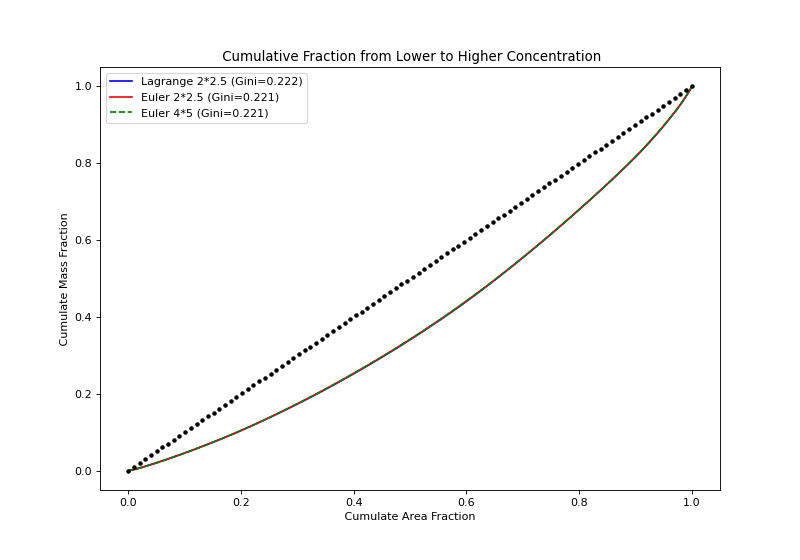

In [49]:
# Plot CFD curve: mass vs. area in the END of the simulation
plt.figure(figsize=(10,7), dpi= 80)

plt.plot(LA0_area_cumsum_frac_time[Nt1-1],LA0_mass_cumsum_frac_time[Nt1-1],'b',label=f'Lagrange 2*2.5 (Gini={Gini_La0:.3f})')

plt.plot(EU1_area_cumsum_frac_time[Nt1-1],EU1_mass_cumsum_frac_time[Nt1-1],'r',label=f'Euler 2*2.5 (Gini={Gini_Eu1:.3f})')
plt.plot(EU2_area_cumsum_frac_time[Nt1-1],EU2_mass_cumsum_frac_time[Nt1-1],'g--',label=f'Euler 4*5 (Gini={Gini_Eu2:.3f})')

diag = np.linspace(0,1,100)
plt.plot(diag,diag,'k.')


#plt.legend(loc='upper left')
plt.title(' Cumulative Fraction from Lower to Higher Concentration')
plt.xlabel(' Cumulate Area Fraction ')
plt.ylabel(' Cumulate Mass Fraction ')
plt.legend()

plt.savefig('CDF_Area_Mass.png')
plt.clf();
plt.cla();
plt.close();

Image('CDF_Area_Mass.png') 

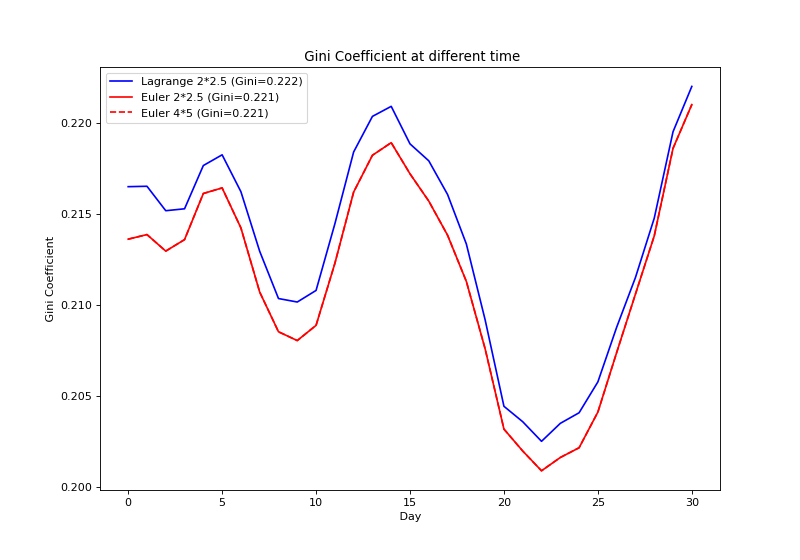

In [50]:
# Plot Gini coefficient at different time:

plt.figure(figsize=(10,7), dpi= 80)

plt.plot(Gini_La0_time,'b',label=f'Lagrange 2*2.5 (Gini={Gini_La0:.3f})')

plt.plot(Gini_Eu1_time,'r',label=f'Euler 2*2.5 (Gini={Gini_Eu1:.3f})')
plt.plot(Gini_Eu2_time,'r--',label=f'Euler 4*5 (Gini={Gini_Eu2:.3f})')



#plt.legend(loc='upper left')
plt.title(' Gini Coefficient at different time')
plt.xlabel(' Day ')
plt.ylabel(' Gini Coefficient ')
plt.legend()

plt.savefig('Gini_time_series.png')
plt.clf();
plt.cla();
plt.close();

Image('Gini_time_series.png') 